In [1]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import decision_trees_helper as dthelp
%aimport decision_trees_helper

import os 

TITANIC_PATH = os.path.join("./external/jack-dies", "data")

train_data_titanic = pd.read_csv( os.path.join(TITANIC_PATH, "train.csv") )
test_data_titanic  = pd.read_csv( os.path.join(TITANIC_PATH, "test.csv")  )



# Decision Trees

- Is a model
    - $ \hat{y} = h_\Theta(X)$
    - $\Theta$ is a nested list of "questions" (a tree)
        - a question is a comparison of a feature to a threshold value
            - $(j, k)$: "Is $X_j \le t_k$"
- The sequence of questions along a path from the root of the tree
    - partition the observations in the train set
    - the final partition along the path ("a leaf") is used for prediction

## Illustration: Titanic
Let's look at an example: a decision tree for surviving the Titanic

In [3]:
th = dthelp.TitanicHelper()
th.make_titanic_png()

SexToInt:transform: Cheating alert!, X has 2 columns.


'images/titanic_2level'

![](images/titanic_2level.png)

- Root
    - Full set of 891 train observations
    - `Survive = No` for 549; `Survive == Yes` for 342
    - `No` is most frequent value, so prediction (`Class`) for root is `No` (orange)

- First question (root)
    - Is `Sex == Male (0)` ?
        - n.b., this is our somewhat wrong initial model (e.g., Sex is binary numeric)

- Partitions the 891 observations at root into
    - Left sub-tree (Male)
        - 577 train observations
        - `Survive = No` for 468; `Survive = Yes` for 109
        - `No` is most frequent value, so prediction (`Class`) for left subtree is `No`
    - Right sub-tree (Female)
        - 314 train observations (891 from parent, less 577 from sibling)
        - `Survive = No` for 81; `Survive = Yes` for 233    
        - `Yes` is most frequent value, so prediction (`Class`) for right subtree is `Yes`

- leaves
    - left blue
        - only 24 Males children <= 6.5, two thirds survived
        - Males older than 6.5: most died
    - right blue
        - Female, hi fare almost certainly survived 1:17, high purity (low gini)
  
So each question along path partitions the parent subset into complementary subsets

## How do we construct the Decision Tree

 Notation
- $i$ is a node
- $j$ is the index of a feature, threshold value $t_j$ from set $T_j$ with cardinality $k$
   
    
- So a node is represented as a pair $(j,t_j)$ corresponding to the test
    - $x_j \le t_j$ where $t_j \in  T_j$

## Definitions
**Set of observations at a node**

Suppose we are at node $n$ of the tree

Let $S_n$ be the subset of labelled train observations (feature, label) pairs associated with node $n$ in the tree

$S_n = \{ (X^{(i)}, y^{(i)}) | i = 1, \dots m_n \}$

**Set of possible threshold values for a feature**

Let $T_j$ be the set of values possible for feature $j$ ($X_j$)

- $X_j$ is categorical with possible values $c \in C$ where $C =  \{ c_1, c_2, \ldots , c_k \}$
     - $T_j = C$

- Feature $j$ is numeric with distinct values (across $m$ observations): $N = \{ x^{(i)}_j | i=1, \dots, m  \}$
    - $T_j = N$

- Note: this is equivalent to one-hot encoding of both categorical and numeric features
    - $1_{x_j = t_k}$ for $k \in \{ 1, \ldots, | T_j | \}$

**Split (question)**

A split ("question") of $S_n$ is a pair $(j, t_k)$ where
   - $j$ is the index of a feature, e.g, $X_j$
   - $k$ is an index in the set of possible threshold values $T_j$
   - question splits $S_n$ into
       - $L_n = \{ (X^{(i)}, y^{(i)}) \in S_n | X^{(i)}_j \le t_k \}$
       - $R_n = \{ (X^{(i)}, y^{(i)}) | X^{(i)}_j  > t_k \}$

## Algorithm

[sklearn manual](https://scikit-learn.org/stable/modules/tree.html#mathematical-formulation)

Recursively partition $S$, constructing a tree of splits

`split(S, parent)`: create a left and right subtree, which are children of `parent`
   - Find the "best" split of $(j, k)$ of $S$ (i.e.,, test $X_j \le t_k$)
   - If such a $(j, k)$ exists
       - split $S$ into $L$ and $R$
       - create left child of `parent` as `split(L, N)`
       - create right child of `parent` as `split(R, N)`
 

Questions
- What is the "best" $(j,k)$ ?
- What does it mean for $(j, k)$ to not exist ?

        

### Measuring the quality of a split

- Intuitively, the observations at each node contains a mixture of target values.
- A good prediction occurs when the observations at a node contain more "correct" targets than incorrect
- Ideal: split creates an $L$ and/or $R$ where all targets are *identical*

We will explore measures that quantify how "impure" (mixed up targets) each node is.

The Gini score is the first of two measures we will explore.

### How good is the split $(j,k)$ ?: Classification target - Gini score

For node $i$:
- Let $p_{i,k}$ be the fraction of node $i$ observations that are in target class $k$
    

$
G_i = 1 - \sum\limits_{k=1}^{n}{{p_{i,k}}^2}
$

$G_i$ is called the **impurity** of node $i$

Goal is to have pure nodes, i.e., all observations in node $i$ are in same target class.

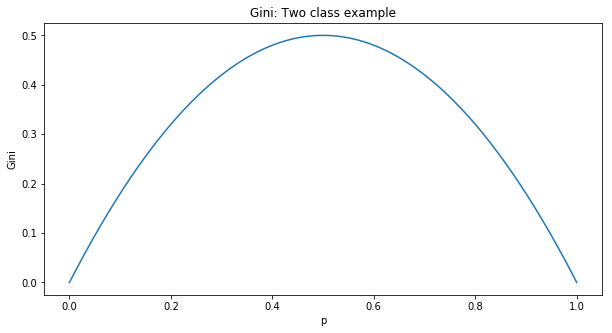

In [4]:
gh = dthelp.GiniHelper()
_ =gh.plot_Gini()

#### Gini illustration

It will be easiest to illustrate with a toy example having only categorical features.

In [5]:
gh = dthelp.GiniHelper()
gh.make_logicTree_png()

'images/logic_tree'

Here are the observations

In [6]:
df_lt = gh.df_lt
df_lt

,feat 1,feat 2,feat 3,target
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,1,1,1
4,1,0,0,0
5,1,0,1,1
6,1,1,0,0
7,1,1,1,1


![](images/logic_tree.png)

Let's compute Gini of the root

In [7]:
gini_lt = gh.gini(df_lt, gh.target_name_lt, gh.feature_names_lt, noisy=True)

print("\n\nMethod returns ", gini_lt)

Gini, by hand:
Count by target:
	
0    5
1    3
Name: target, dtype: int64
Frequency by target:
	
0    0.625
1    0.375
Name: target, dtype: float64

1 - sum(freq**2) = 0.469


Method returns  0.46875


And Gini of the right sub-tree

In [8]:
df_right = df_lt[ df_lt["feat 3"] > 0.5 ]

gh.gini( df_right, gh.target_name_lt, gh.feature_names_lt, noisy=True)

Gini, by hand:
Count by target:
	
1    3
0    1
Name: target, dtype: int64
Frequency by target:
	
1    0.75
0    0.25
Name: target, dtype: float64

1 - sum(freq**2) = 0.375


0.375

#### The "best" ($j,k)$ split: From Gini of children, to Cost for split at parent

Now that we can measure the impurity of a set of observations, we can associate a Cost with the choice of split of $(j, k$) of $S_n$:
- $\text{Cost}_{j,k}(S) = \frac{m_L}{(m_L + m_R)} G_L + \frac{m_R}{(n_L + m_R)} G_R$

That is, the Cost of splitting $S_n$ on $X_j \le t_k$ is the weighted sum of the Gini's of the partiions created.

So we now have a method for determining the "best" split of $S_n$: one that minimizes the Cost.

$ j, k = \text{argmin}_{j,k} { \text{Cost}_{j,k} }$

Let's examine the cost of split at the root for each (binary) feature

In [9]:
gh.cost(df_lt, gh.target_name_lt, gh.feature_names_lt, noisy=True)

Split feature feat 1 on 0.00
	G_left (# = 4) = 0.375, G_right (# = 4) = 0.500
	weighted (G_left, G_right) = 0.438
Split feature feat 2 on 0.00
	G_left (# = 4) = 0.375, G_right (# = 4) = 0.500
	weighted (G_left, G_right) = 0.438
Split feature feat 3 on 0.00
	G_left (# = 4) = 0.000, G_right (# = 4) = 0.375
	weighted (G_left, G_right) = 0.188


0.1875

So split on $(3, 0)$ (feature "feat 3", threshold 0) gives the minimum cost.

That explains the split at the root.

### Can a "best" split not exist ?

Yes.
- if $| S | == 0$
- if $\text{Cost}(S) > G_S $
    - split results in children which are more impure that parent
    
Our algorithm works when the Cost (weighted Gini) of the split is less than the Gini of the node.

This is a type of "information gain".

### Why not continue all the way to leaves with single observations

Overfitting.

### Aside: One-hot encoding for categorical vs. numerical

The Decision Tree split is a good illustration of the difference between one-hot encoded categoricals and numeric encoded categoricals

- Consider $\text{PClass} \in \{1,2,3\}$
- As a numeric, $\text{PClass}$ implies an ordering (magnitude doesn't matter for Decision Tree split)
- So 
    - numeric $\text{PClass}: \lnot (\text{PClass} \le 2)$ includes $\{ 3 \}$
    - one-hot $\text{PClass}: \lnot 1_{\text{PClass}=2}$ includes $\{ 1, 3 \}$

Not the same !

## Decision Tree Regression

- Very similar to Clasification
- Prediction at node $n$: the average of $y$ that occurs in $S_n$
- use MSE rather than Gini as measure of impurity
             
                    
- Doesn't extrapolate at all: just clips at extreme prediction

### How good is the split $(j,k)$ ?: Regression target - MSE

**Equation 6-4: CART cost function for regression**

$
J(j, t_k) = \dfrac{m_{\text{left}}}{m}\text{MSE}_\text{left} + \dfrac{m_{\text{right}}}{m}\text{MSE}_{\text{right}} \quad
\text{where }
\begin{cases}
\text{MSE}_{\text{node}} = \sum\limits_{\scriptstyle i \in \text{node}}(\hat{y}_{\text{node}} - y^{(i)})^2\\
\hat{y}_\text{node} = \dfrac{1}{m_{\text{node}}}\sum\limits_{\scriptstyle i \in \text{node}}y^{(i)}
\end{cases}
$

### Overfitting: why not continue too deep ?
- A binary tree of depth $d$ can have as many as $2^d$ leaves
    - be careful if number of observations $m < 2^d$
       
    - memorize training set; poor generalization

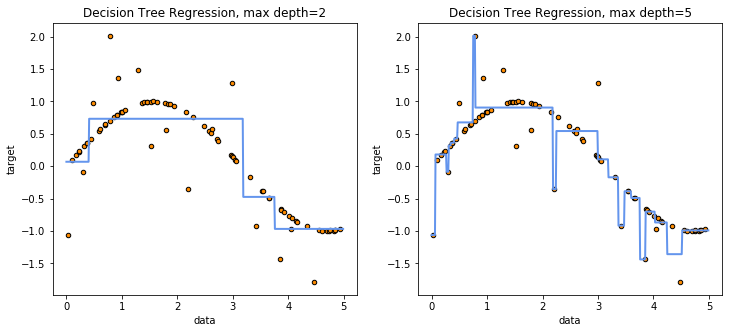

In [10]:
rh = dthelp.RegressionHelper()

_ =rh.make_plot()

![](images/tree_regress_depth_2.png)

## Advantages and Drawbacks

n.b., beware of unbalanced datasets
    - balance if it is not representative
    
### Advantage
- highly interpretable

### Disadvantages
- Overly complex at times
- Easy to overfit
- No ability to extrapolate
    - clipped at min/max of feature range
- *Greedy* algorithm: not guaranteed to be optimal
    - No true "best"; problem is NP-complete

You can combat overfitting with several parameters
- `max_depth`: maximum depth of tree
- `min_samples`: minimum size (no. of observations) to split a node
- `min_samples_leaf`: minimum number of samples for a leaf

# Ensembles

Why use a single model when  you can use many ?

Can apply ensemble method to any model, or even a mixture of models

We will illustrate with ensembles of Decision Trees: Random Forest

- Replace **strong learner**: single complex model (e.g., deep tree) 
- with many **weak learners**: simple models (e.g, restricted trees) 
    - restrict in split choice, depth
- Prediction
    - each weak learner predicts; voting on single prediction

<div class="alert alert-block alert-warning">
    <b>Note:</b> 
    <ul>
        <li>Ensembles combine multiple weak learners into a strong, single learner.</li>
        <li>The learners are often, but not necessarily, Decision Trees.</li>
</div>

# Random Forests

- Addresses some drawbacks of Decision Trees
- Introduces Ensemble methods
- Combines "weak learners": preview of boosting

## Avoiding a poor training set
- Decision Trees very sensitive to training set
    - what if we were unlucky ?

### Bootstrapping
- Suppose you had a fair coin; it's still possible to get an unlucky sample
- Let's assume training set is a fair representation of the true distribution
    - create new training set of same size
    - random sampling *with replacement*
    -  you wind up with many representative training sets, some lucky, some not
    

## Avoid poor, greedy choices
- At each level of tree, limit choice of (feature number, threshold) on which to split to $k$ random available choices
- That's what makes this a "weak" learner: absence of full choice
    - but may avoid bad greedy choice
- NOTE: there are potentially a lot of choices
    - for categorical feature $c$ with possible values from set $C$, there are $|C|$ choices
    - for numeric features the choices are each distinct value among the $m$ observations
    

## Bagging

When we bootstrap a training set to create multiple models, and aggregate predictions of models into single prediction, this is called **bagging**

Because we sample with replacement, in each bootstrapped sample there will be observations from the train set that are not included.

These are called **out of bag** and may be used for validation.

## Algorithm
- Decide how many $d$ Decision Trees to create
- `for t in range(0,d):`
    - bootstrap a new training set $S_t$ from $S$ &nbsp; s.t., $|S_t| = |S|$
    - create decision tree $T_t(S_t, k)$
        - Training set is $S_t$, **not** S
        - at each split, limit set of choices ($j, t_j$) to size $k$
- Result is a forest of $d$ trees: $\{ T_t | t = 1, \dots, d \}$

`split(S, parent, k)`: create a left and right subtree, which are children of `parent`
   - Let $F = \{ X_j | j  = 1, \dots, n \}$ denote the full set of features.
       - Randomly choose a subset $F_k \subset F$ where $| F_k | = k$ 
   - Find the "best" split $(j, k)$ of $S$ &nbsp; (i.e., test $X_j \le t_k$), where $X_j \in F_k$
   - If such a $(j, k)$ exists
       - split $S$ into $L$ and $R$
       - create left child of `parent` as `split(L, N, k)`
       - create right child of `parent` as `split(R, N, k)`
    - `split(R, N)

## Prediction in a Forest

There are now $d$ trees, each created independently.

To predict for $X_{\text{test}}^{(i)}$:
- predict for each tree
    - So have a set of $d$ predictions: $P = \{ \hat{y}_t | t = 1, \ldots, d \}$
- single prediction based on votes in $P$

# Boosting

Boosting, like Ensembling, constructs multiple weak learners and combines them into a single strong learner.

But the learners contructed by Ensembling are **independent** of one another.

In contrast, Boosting constructs a **sequence**: 
    - the next learner compensates for the weakness of the current learner.

We will illustrate, again, with Decision Trees.

<div class="alert alert-block alert-warning">
    <b>Note:</b> 
    <ul>
        <li>Ensembling contructs a <i>set</i> of weak, independent learners.
        <li>
            Boosting constructs a <i>sequence</i> of weak learners
                <ul>
                    <li>Each successive learner in the sequence depends on it's predecessors</li>
            </ul>
        </li>
        <li>
    The learners are often, but not necessarily, single level Decision Trees ("stumps")
            </li>
    </div>

The most powerful class of Boosting techniques is called Gradient Boosting.

We will start with a special case: AdaBoost.

## Algorithm

Idea
- observations will be assigned weights that will change during the sequence
- The subsequent learner will try to correct the misclassifications of the current
    - by increasing weights of the misclassified observations and decreasing weights of correctly classified
- Not all weak learners have an equal vote in the aggregated prediction
    - better classifiers have more weight ("say", so as not to confuse with observation weight)

Construct the sequence:   
- assign equal weights to each observation in the training set

- `for i in range(0,W):`:
    - Construct weak learner $W_i$
        - Impurity calculated on a (observation) weighted basis
        - $\text{say}_i =$ sum of weights of correctly classified observations
        - re-weight observations
            - increase ("boost") weights of observations correctly classified by $W_i$
            - decrease weights of observations correctly classified by $W_i$
            - boost/decrease increases with $\text{say}_i$
            

# Entropy

We will study Entropy for two reasons
- an alternative to Gini for deciding which variable/what threshold to use in constructing a Decision Tree
- a Cost measure for Classification (Cool Cost Function ?)

- A measure of the randomness of a distribution
- Interpreted as the number of bits of information obtained from a single sample

## What is a bit ?
- Amount of information need to reduce uncertainly by a factor of 2


### Example: what is a bit

Here, a bit is the amount of information **not** a length of the message

**Simple case: two equally probable outcomes**

Two outcomes: Rain, Sun
$$    
\begin{array}{lll}
\text{Rain} & .5 \\
\text{Sun}  & .5
\end{array}
$$

Uncertainty about Rain is .5

If I tell you that it will Rain (so $p_{\text{Rain}} = 1$) I've reduced the uncertainty
by
$$
{1 \over .5} = 2
$$

$\log_2 (2) = 1$ 

so this conveyed 1 bit of *information* regardless of how many *physical* bits were sent.

**Uncertainty reduction**

One bit reduces uncertainty ($1/p$) by a factor of $2$.

$\log_2 (1/p) = - \log_2(p)$ 

**Simple case: 4 equally probable outcomes**

4 outcomes: Rain, Sun, Clouds, Drizzle
$$    
\begin{array}{lll}
\text{Rain} & .25 \\
\text{Sun}  & .25 \\
\text{Clouds} & .25 \\
\text{Drizzle} & .25
\end{array}
$$

Uncertainty about Rain is .25.

If I tell you that it will Rain (so $p_{\text{Rain}} = 1$) I've reduced the uncertainty
by
$$
{1 \over .25} = 4
$$

so this is $- \log_2 (.25) = 2$ bits of information.

**Outcomes with arbitrary probabilities**

Two outcomes with unequal probability: Rain, Sun
$$    
\begin{array}{lll}
\text{Rain} & .25 \\
\text{Sun}  & .75
\end{array}
$$

If I tell you that it will Rain (so $p_{\text{Rain}} = 1$) I've reduced the uncertainty
by
$$
{1 \over .25} = 4
$$

so this is $\log_2 (2) = 2$ bits of information.

If I tell you that there will be Sun (so $p_{\text{Sun}} = 1$) I've reduced the uncertainty
by
$$
{1 \over .75}
$$

so this is $- \log_2 (0.75) = 0.415$ bits of information.

### Average number of bits in a sample

The average number of bits (*information*) in a sample randomly drawn from the distribution is

$
H_i = -\sum\limits_{k=1 \atop p_{i,k} \ne 0}^{n}{{p_{i,k}}\log_2(p_{i,k})}
$

For the 75%/25% case above

$
H_i = 0.75 * 0.415 + 0.25 * 2 = 0.81
$
This is also called the **entropy**

It measures the unpredictability of the distribution.


### A pure distribution has 0 entropy

Since $p_{i,k} = 1, log(p_{i,k}) = 0$

#### Back to Decision Trees: Entropy as a measure of impurity

Entropy is like Gini in that it is a measure of the impurity of a distribution (i.e., observations in a node).

One may use Entropy or Gini as the measure for constructing Decision Trees.

But Entropy (and it's cousin Cross Entropy) pops up all over in ML, so we'll leave Decision Trees for a moment
and explore this topic for its own sake.

# Cross entropy

<div class="alert alert-block alert-warning">
    <b>TL;DR</b> 
    <ul>
        <li>Cross Entropy measures the "distance" between two distributions </li>
            <li>You will often come across Cross Entropy and KL Divergence in  your future ML endeavours.</li>
        </div>        

Similar to Entropy but 
- use true probability (as weights)
- number of bits implied from estimated probability

**Cross entropy between two discrete probability distributions $p$ and $q$:**

$ H(p, q) = -\sum\limits_{x}p(x) \log q(x) $
- if distributions $p(x), q(x)$ are the same
    - cross entropy equals entropy $H(p,p) = H(p)$
- $(H(p,q) - H(p))$ is called the *Kullback-Liebler* or KL divergence.

**Aside**

There is another interpretation of Cross Entropy.

We've seen that the amount of information depends on the number of bits that each outcome $k$ gives: $\log_2(p_{i,k})$.

If the number of *physical* bits (message length) is different than $\log_2(p_{i,k})$, then this is *optimal* only if the distribution is some other $q_{i,k}$

$ H(p, q) = -\sum\limits_{x}p(x) \log q(x) $
is the average *physical* length of the message.

The physical length will equal the information content only if $p(x) = q(x)$

## Cross entropy in Machine Learning

For classification with a multinomial target with $k$ possible values
- we can train $k$ binary classifiers, each producing a score $s_k$
- use softmax to translate each of the $k$ scores into a probability
- so the softmax produces a probability distribution over $k$ outcomes

**Softmax score for class k**

$
s_k(\mathbf{x}) = ({\boldsymbol{\theta}^{(k)}})^T \mathbf{x}
$


**Scores to probabilities via Softmax**

$
\hat{p}_k = \sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum\limits_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}}
$


**Prediction is class with highest probabiity**

$
\hat{y} = \underset{k}{\operatorname{argmax}} \, \sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \underset{k}{\operatorname{argmax}} \, s_k(\mathbf{x}) = \underset{k}{\operatorname{argmax}} \, \left( ({\boldsymbol{\theta}^{(k)}})^T \mathbf{x} \right)
$

As written above, there is no single Cost function that can be minimized.

We can think of our target $y$, from multinomial class $C$, encoded via one-hot encoding, as a probability distribution.

$
p^{(i)} = \{ 1_{y^{(i)} = c_k } | c_k \in C \}
$

So we create a Cost function that minimizes  the distance between
the target distribution $p^{(i)}$ and the predicted distribution $\hat{p}^{(i)}$
over all Train observations $i$

**Cross entropy cost function**

$
J(\boldsymbol{\Theta}) = - \dfrac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}
$

**Recall**
$ H(p, q) = -\sum\limits_{x}p(x) \log q(x) $

**Cross entropy gradient vector for class _k_**

$
\nabla_{\boldsymbol{\theta}^{(k)}} \, J(\boldsymbol{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}
$

Observe that the gradient involves the prediction error $\left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) $

## Logistic Regression re-visited

**Cost function of a single training instance**

$
c(\boldsymbol{\theta}) =
\begin{cases}
  -\log(\hat{p}) & \text{if } y = 1, \\
  -\log(1 - \hat{p}) & \text{if } y = 0.
\end{cases}
$

Over all training instances, the Loss is:

**Logistic Regression cost function (log loss)**

$
J(\boldsymbol{\theta}) = -\dfrac{1}{m} \sum\limits_{i=1}^{m}{\left[ y^{(i)} log\left(\hat{p}^{(i)}\right) + (1 - y^{(i)}) log\left(1 - \hat{p}^{(i)}\right)\right]}
$

The above looks just like Cross Entropy between true distribution $y$ and the predicted distribution $\hat{p}$

Note, $y^{(i)} \in \{0,1\}$ so the two addends are really just true probability ($y^{(i)}$) times predicted probability $\hat{p}^{(i)}$

We can use Gradient Descent to minimize this Cost function, by taking its derivative.

**Logistic cost function partial derivatives**

$
\dfrac{\partial}{\partial \theta_j} \text{J}(\boldsymbol{\theta}) = \dfrac{1}{m}\sum\limits_{i=1}^{m}\left(\mathbf{\sigma(\boldsymbol{\theta}}^T \mathbf{x}^{(i)}) - y^{(i)}\right)\, x_j^{(i)}
$

Look familiar ? 

Looks similar to the derivative for Linear Regression, except for the prediction
being $\mathbf{\sigma(\boldsymbol{\theta}}^T \mathbf{x}^{(i)})$
(i.e., linear prediction run through the sigmoid $\sigma$))
rather than
$\mathbf{\boldsymbol{\theta}}^T \mathbf{x}^{(i)} $

In [11]:
print("Done")

Done
